# Работа с целевой переменной


# Из методички

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Отбор признаков по важности**

In [145]:
from sklearn.datasets import fetch_openml

In [146]:
df = fetch_openml("mtp", version=1)
df.data.head()

,oz1,oz2,oz3,oz4,oz5,oz6,oz7,oz8,oz9,oz10,...,oz193,oz194,oz195,oz196,oz197,oz198,oz199,oz200,oz201,oz202
0,0.076923,0.325000,0.035088,0.200000,0.162112,0.194562,0.003900,0.060606,0.166667,0.045872,...,0.013874,0.071602,0.056880,0.179132,0.505899,0.039213,0.091327,0.321109,0.127564,0.188387
1,0.230769,0.375000,0.042105,0.333333,0.464191,0.622795,0.077623,0.373737,0.305556,0.192661,...,0.006342,0.186056,0.287438,0.384236,0.683820,0.326584,0.117990,0.456665,0.475618,0.401935
2,0.269231,0.437500,0.052632,0.333333,0.506556,0.531840,0.054374,0.212121,0.333333,0.229358,...,0.005018,0.179544,0.117431,0.384550,0.499219,0.204885,0.155967,0.360441,0.497968,0.407742
3,0.153846,0.357143,0.039474,0.266667,0.352880,0.394131,0.019654,0.171717,0.277778,0.091743,...,0.004801,0.091771,0.145349,0.243064,0.630533,0.023469,0.124430,0.336023,0.134458,0.252258
4,0.153846,0.357143,0.039474,0.266667,0.350523,0.320546,0.013154,0.101010,0.166667,0.110092,...,0.011166,0.130755,0.067583,0.250832,0.516053,0.111398,0.125693,0.332113,0.295913,0.253548


Давайте построим распределение целевой переменной.

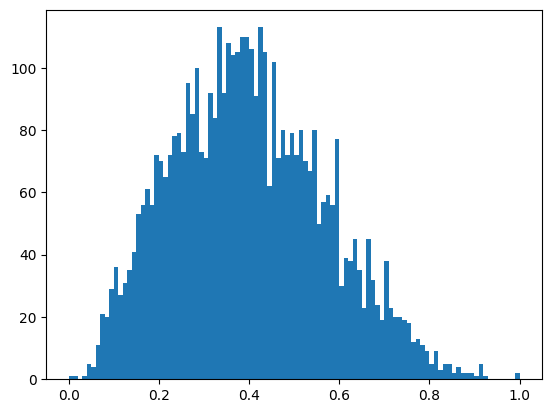

In [147]:
plt.hist(df.target, 100)
_ = plt.plot()

Мы видим, что целевая переменная представляет собой численное значение, что определяет задачу моделирования как регрессию. Кроме того, график показывает, что распределение имеет форму, сходную с нормальным.

**Построение базовой (baseline) модели**

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [149]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42)

В качестве базовой модели лучше выбрать простую (вычислительно) модель, которая, желательно, обладает высокой интерпретируемостью. Для этого лучше всего подходят линейные модели и деревья решений. В данном случае, воспользуемся моделью линейной регрессии.

In [150]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

LinearRegression()

В данном случае, мы оценивает тестовую эффективность базовой модели по метрике R-квадрат.

In [151]:
bl_score = baseline.score(X_test, y_test)
bl_score

-1.6511340762242646

In [152]:
y_pred = baseline.predict(X_test)

Базовая модель показывает очень низкую эффективность — хуже случайных прогнозов и среднего значения. Проблема в высокой вариативности и переобучении из-за большого числа признаков, многие из которых не полезны. Это увеличивает сложность модели без улучшения качества.

Полезно добавить на график линию регрессии, чтобы визуально оценить качество предсказаний.

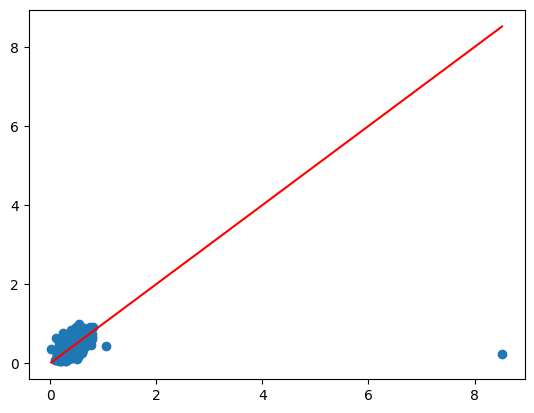

In [153]:
plt.scatter(y_pred, y_test)
min_val = min(y_pred.min(), y_test.min())
max_val = max(y_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], c='r')

**Определение относительной важности признаков**

Чтобы улучшить модель, нужно убрать лишние признаки. Полный перебор (например, рекурсивное исключение или добавление признаков) слишком ресурсоёмок при 200+ признаках.

Вместо этого можно использовать парные статистики, например, коэффициент корреляции, чтобы отобрать признаки, наиболее связанные с целевой переменной. Но этот способ учитывает только линейные связи.

Более эффективно использовать важности признаков, которые даёт нелинейная модель, например, случайный лес. Он оценивает влияние признаков с учётом сложных зависимостей и позволяет автоматически выбрать значимые переменные без дополнительного перебора.

In [154]:
from sklearn.ensemble import RandomForestRegressor

In [155]:
rf = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)

По сути, случайный лес - это набор деревьев, каждый из которых видит случайную часть выборки.

Сейчас важно, что при помощи свойства feature_importances_ можно получить информацию о важности признаков. Удобнее всего изобразить эту информацию на графике в отсортированном виде.

Text(0.5, 0, 'Feature Importance')

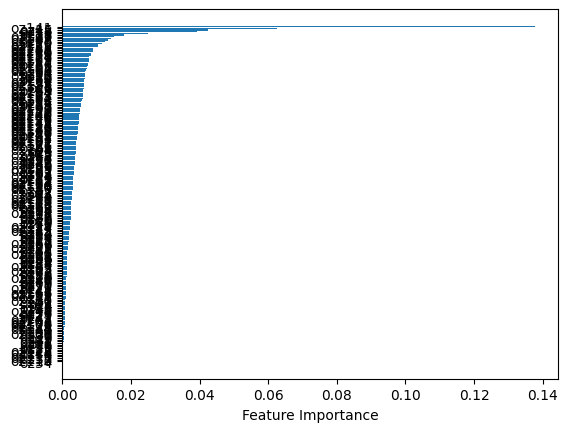

In [156]:
sort = rf.feature_importances_.argsort()
plt.barh(df.data.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

Мы получим столбчатый график, на котором по вертикали отложены все наши признаки, они подписаны слева вдоль вертикальной оси, по горизонтали - отложена относительная важность данного признака. Это условное число, которое показывает, насколько информативен данный признак для предсказания значения целевой переменной.

Из-за того, что у нас более 200 признаков, подпись мало читаются. Можете самостоятельно построить более читаемый график, отобрав, например, только 30 самых значимых признаков.

In [157]:
rf.feature_importances_[sort][-10:]

array([0.01260502, 0.01329625, 0.01420165, 0.01507921, 0.01794745,
       0.02491877, 0.03916479, 0.042406  , 0.06270916, 0.13763302])

Более интересна и полезна для нас информация о названиях самых важных признаков.

In [158]:
df.data.columns[sort][-10:]

Index(['oz20', 'oz198', 'oz47', 'oz197', 'oz137', 'oz18', 'oz35', 'oz48',
       'oz15', 'oz141'],
      dtype='object')

Теперь можно использовать важности признаков, чтобы удалить лишние. Сколько оставить — выбираем сами. Часто используют "метод локтя", но для простоты сейчас оставим 20 самых важных.

In [159]:
trimmed = df.data[df.data.columns[sort][-20:]]
trimmed.head()

,oz109,oz117,oz178,oz159,oz180,oz201,oz158,oz153,oz112,oz155,oz20,oz198,oz47,oz197,oz137,oz18,oz35,oz48,oz15,oz141
0,0.076923,0.000000,0.007949,0.929724,0.002655,0.127564,0.800120,0.052296,0.000000,0.752291,0.000000,0.039213,0.102941,0.505899,0.000000,0.0625,0.0,0.312855,0.000000,0.041308
1,0.153846,0.311793,0.008435,0.944542,0.002581,0.475618,0.791224,0.060922,0.222222,0.745984,0.242424,0.326584,0.389706,0.683820,0.278945,0.0625,0.4,0.297041,0.282828,0.212274
2,0.076923,0.000000,0.008192,0.946121,0.002722,0.497968,0.798276,0.072628,0.000000,0.753298,0.388889,0.204885,0.257353,0.499219,0.000000,0.1250,0.0,0.288557,0.388889,0.063643
3,0.076923,0.000000,0.008107,0.945087,0.002473,0.134458,0.800965,0.054593,0.000000,0.767469,0.095238,0.023469,0.198529,0.630533,0.039437,0.0000,0.1,0.310692,0.111111,0.031193
4,0.076923,0.000000,0.008274,0.941644,0.002810,0.295913,0.802893,0.045400,0.000000,0.741548,0.260870,0.111398,0.154412,0.516053,0.000000,0.0625,0.0,0.286581,0.304348,0.063643


Теперь все готово для того, чтобы построить модель на урезанном датасете.

In [160]:
X_train, X_test, y_train, y_test = train_test_split(trimmed, df.target, test_size=0.25, random_state=42)

In [161]:
better = LinearRegression()
better.fit(X_train, y_train)

LinearRegression()

Мы используем тот же класс моделей - линейную регрессию - чтобы различия в метрике были сопоставимы. И мы получаем гораздо более качественную модель. Метрика уже положительна, что свидетельствует о большом росте точности.

In [162]:
print(bl_score)
better.score(X_test, y_test)

-1.6511340762242646


0.3943784262021778

In [163]:
y_pred = better.predict(X_test)

Можно изобразить график модели и визуально, чтобы убедиться в том, что он разительно отличается от графика, который мы получили ранее.

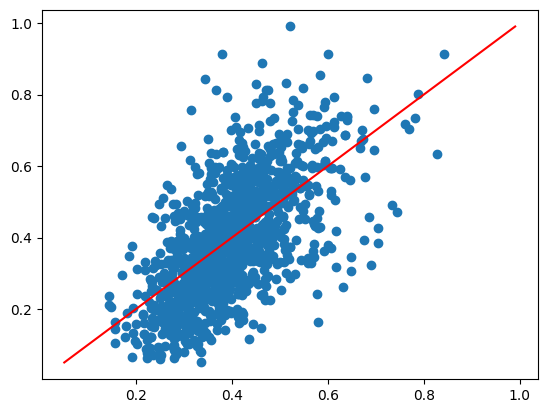

In [164]:
plt.scatter(y_pred, y_test)
min_val = min(y_pred.min(), y_test.min())
max_val = max(y_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], c='r')

**Автоматизация отбора признаков**

Отбор признаков — стандартная часть моделирования. В прошлый раз мы делали это вручную, но в sklearn есть удобные встроенные инструменты, например SelectFromModel из модуля feature_selection. Он позволяет выбрать важные признаки на основе модели машинного обучения.

In [165]:
from sklearn.ensemble import RandomForestRegressor

In [166]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(RandomForestRegressor(n_estimators=15)).fit(df.data, df.target)
X_trimmed = sfm.transform(df.data)
X_trimmed.shape

(4450, 57)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, df.target, test_size=0.25, random_state=42)

better = LinearRegression()
better.fit(X_train, y_train)

print(bl_score)
better.score(X_test, y_test)

-1.6511340762242646


0.4358871768813247

R²-метрика улучшилась — значит, увеличение числа информативных признаков до 55 не вызвало переобучения.

**Устранение дисбаланса классов**

Одной из частых проблем в классификации на реальных данных является дисбаланс классов — ситуация, когда один класс представлен гораздо чаще других (например, в 10–100 раз). Это мешает модели обучаться, так как она видит преимущественно примеры мажоритарного класса. В результате она может переобучиться на редких классах и недообучиться на частых.

Чаще всего проблему видно в отчёте о классификации: миноритарные классы распознаются хуже всего. Далее рассмотрим это на примере психологического датасета.

In [168]:
df = fetch_openml("balance-scale", version=1)

In [169]:
df.data.head()

,left-weight,left-distance,right-weight,right-distance
0,1,1,1,1
1,1,1,1,2
2,1,1,1,3
3,1,1,1,4
4,1,1,1,5


In [170]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42, stratify=df.target)

In [171]:
baseline = LogisticRegression()
baseline.fit(X_train, y_train)
bl_score = baseline.score(X_test, y_test)
bl_score

0.8598726114649682

In [172]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, baseline.predict(X_test)))

              precision    recall  f1-score   support

           B       0.00      0.00      0.00        12
           L       0.87      0.92      0.89        73
           R       0.86      0.94      0.90        72

    accuracy                           0.86       157
   macro avg       0.58      0.62      0.60       157
weighted avg       0.80      0.86      0.83       157



In [173]:
print(confusion_matrix(y_test, baseline.predict(X_test)))

[[ 0  6  6]
 [ 1 67  5]
 [ 0  4 68]]


Посмотрим, можно ли улучшить модель при дисбалансе классов. Рассмотрим две стратегии: взвешивание классов и ресемплинг.

Проблема дисбаланса — в недостаточном внимании к редким классам. Это можно компенсировать, задав веса классам, обратно пропорциональные их доле в данных. В sklearn есть встроенная возможность для такого взвешивания — параметр class_weight.

In [174]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{'B': np.float64(4.216216216216216),
 'L': np.float64(0.7255813953488373),
 'R': np.float64(0.7222222222222222)}

Мы видим, что вес миноритарного класса действительно вильно больше, чем двух других. Эту информацию можно передать непосредственно модели машинного обучения через параметр конструктора:

In [175]:
from sklearn.linear_model import LogisticRegression

In [176]:
weighted = LogisticRegression(class_weight=class_weights)
weighted.fit(X_train, y_train)
print(bl_score)
weighted.score(X_test, y_test)

0.8598726114649682


0.9235668789808917

**Oversampling**

Если модель не поддерживает взвешивание классов или этот метод неэффективен, можно использовать ресемплинг — выравнивание распределения классов в выборке.

Есть два подхода:

Оверсемплинг — увеличение числа объектов миноритарного класса (с повторениями).

Андерсемплинг — уменьшение числа объектов мажоритарного класса.

Возможен и гибридный метод.

Также существуют продвинутые методы генерации новых объектов (например, SMOTE). Далее на простом примере покажем, как работает оверсемплинг, начав с подсчёта числа объектов каждого класса в обучающей выборке.

Покажем на простом примере как работает оверсемплинг. Подсчитаем точное количество объектов каждого класса в обучающей выборке.

In [177]:
y_train.value_counts()

,count
class,
R,216
L,215
B,37


Для дальнейших манипуляций нам будет удобно объединить матрицу признаков и вектор целевой переменной в один датафрейм.

In [178]:
X_train["target"] = y_train

Теперь мы семплируем недостающее количество объектов миноритарного класса из нашего датасета с повторениями:

In [179]:
oversampled = X_train[X_train.target == "B"].sample(n=216-37, replace=True, ignore_index=True)

После этого нам остается только объединить эту новую выборку с исходной:

In [180]:
oversampled = pd.concat([X_train, oversampled])
print(oversampled.shape)
oversampled.head()

(647, 5)


,left-weight,left-distance,right-weight,right-distance,target
262,3,1,3,3,R
401,4,2,1,2,L
174,2,2,5,5,R
81,1,4,2,2,B
36,1,2,3,2,R


Иными словами, мы просто добавили дубликаты объектов миноритарного класса в обучающую выборку, чтобы их стало столько же, сколько у мажоритарного. Это позволяет модели «видеть» их чаще и учитывать при обучении наравне с остальными.

Теперь проверим, помог ли этот метод. Для этого снова разделим данные на признаки и целевой вектор и обучим модель.

In [181]:
y_train_OS = oversampled.target
X_train_OS = oversampled.drop(["target"], axis=1)

И построим такую же модель логистической регрессии. Теперь никакое взвешивание классов не понадобится, мы сделали все руками:

In [182]:
OSmodel = LogisticRegression()
OSmodel.fit(X_train_OS, y_train_OS)
print(bl_score)
OSmodel.score(X_test, y_test)

0.8598726114649682


0.9235668789808917

**Дискретизация целевой переменной**

Для освоения следующего приема обработки данных воспользуемся другим датасетом, но из того же репозитория. После чтения сразу подготовим его к моделированию:

In [183]:
df = fetch_openml("CPMP-2015-regression", version=1)
df.data.drop(["instance_id"], inplace=True, axis=1)
df.data = pd.get_dummies(df.data)
df.data.head()

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/list/data_name/cpmp-2015-regression/limit/2/data_version/1. Retrying...
  warn(
<ipython-input-183-fe69465c1096>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.data.drop(["instance_id"], inplace=True, axis=1)


,repetition,stacks,tiers,stack.tier.ratio,container.density,empty.stack.pct,overstowing.stack.pct,overstowing.2cont.stack.pct,group.same.min,group.same.max,...,avg.l1.top.left.lg.group,cont.empty.grt.estack,pct.bottom.pct.on.top,algorithm_astar.symmulgt.transmul,algorithm_astar.symmullt.transmul,algorithm_idastar.symmulgt.transmul,algorithm_idastar.symmullt.transmul,runstatus_memout,runstatus_ok,runstatus_timeout
0,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,True,False,False,False,False,True,False
1,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,True,False,False,False,True,False
2,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,False,True,False,False,True,False
3,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,False,False,True,False,False,True
4,1,16,5,0.3125,0.6,0.1875,0.5625,1.000000,0,7,...,0.663462,0.3375,0.0,True,False,False,False,True,False,False


Это набор данных о бенчмарке решения математической проблемы нахождения оптимальной сортировки на контейнерной площадке. В этом наборе нам более всего важно распределение целевой переменной:

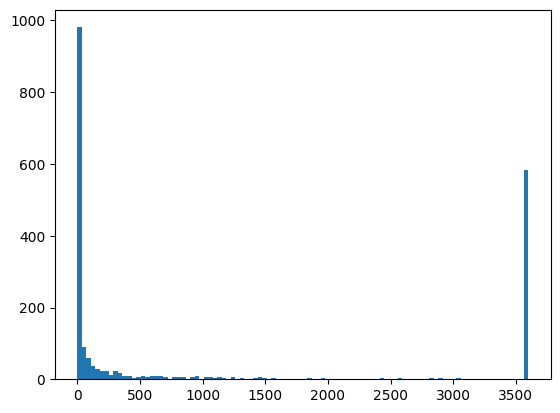

In [184]:
plt.hist(df.target, 100)
_ = plt.plot()

In [185]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42)

Группировать объекты можно опять же по-разному. Для автоматизации этой процедуры в библиотеке sklearn есть специальный объект - KBinsDiscretizer, который находится в пакете preprocessing. Воспользуемся им и создадим, например, пять групп:

In [186]:
from sklearn.preprocessing import KBinsDiscretizer

y_binned = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform").fit_transform(pd.DataFrame(y_train))

В случае таких сильно неравномерных распределений нам больше подойдет другая стратегия - квантильная дискретизация, при которой длина диапазонов выбирается таким образом, чтобы в каждом из них оказалось примерно по одинаковому количеству объектов выборки:

In [187]:
y_binned = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile").fit_transform(pd.DataFrame(y_train))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


# Задания для самостоятельного выполнения

*1. Исследуйте связь между количеством самых важных признаков, которые использует модель для обучения и тестовой точностью получившейся модели. Обучите несколько моделей с разным количеством наиболее важных признаков. Постройте график зависимости точности модели от количества признаков. Сделайте вывод.*

Датасет load_digits - изображения рукописных цифр (0-9), представленные в виде матрицы 8 на 8 (всего 64 признака). Задача - классификаиция цифр.

In [231]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [232]:
data = load_digits()
X, y = data.data, data.target

In [233]:
scaler = StandardScaler() # стандартизация
X = scaler.fit_transform(X)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [235]:
rf = RandomForestClassifier(n_estimators=100, random_state=42) # важность признаков
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_

In [236]:
sorted_indices = np.argsort(feature_importances)[::-1]

In [237]:
num_features_range = range(1, X_train.shape[1] + 1)
accuracies = []

In [238]:
for num_features in num_features_range: # оценка точности
    selected_features = sorted_indices[:num_features]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

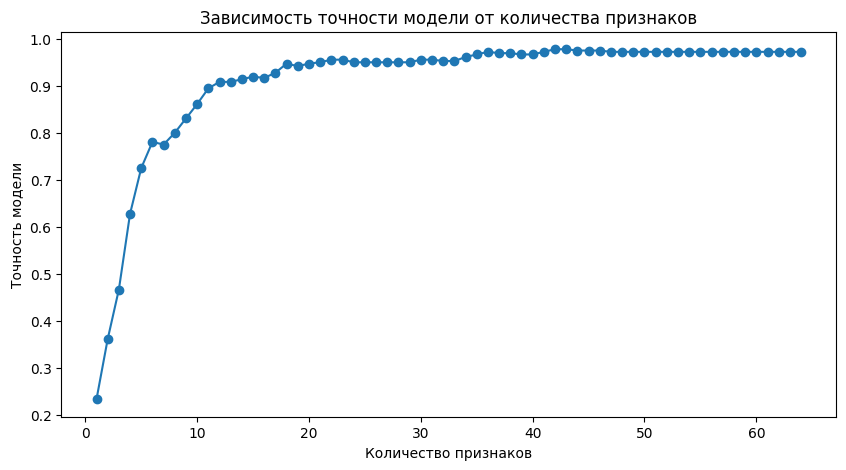

In [239]:
plt.figure(figsize=(10, 5))
plt.plot(num_features_range, accuracies, marker='o', linestyle='-')
plt.xlabel("Количество признаков")
plt.ylabel("Точность модели")
plt.title("Зависимость точности модели от количества признаков")
plt.show()


*2. Используйте другие методы отбора признаков:*

*- Исключение низкодисперсных признаков;*

*- Исключение по парным стаистическим критериям (хи-квадрат, тест Фишера, коэффициент корреляции, информационный критерий);*

*- Рекурсивное исключение признаков;*

*- Последовательное включение признаков;*

*- Исключение по L1-норме (гребневой регрессии).*

Variance Threshold — удаляет признаки с очень маленькой дисперсией (почти не меняются).

Chi-Square (хи-квадрат) — проверяет статистическую зависимость категориальных признаков от целевой переменной.

Recursive Feature Elimination (RFE) — рекурсивно удаляет наименее важные признаки, обучая модель повторно.

Sequential Feature Selection — последовательно добавляет признаки, выбирая те, что улучшают модель.

L1 Regularization (Lasso) — обнуляет коэффициенты у неважных признаков при обучении линейной модели с L1-регуляризацией.

In [240]:
from sklearn.feature_selection import SelectKBest, chi2, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import Lasso

In [241]:
methods = {
    "Variance Threshold": lambda X, y: np.argsort(VarianceThreshold(threshold=0.01).fit(X).variances_)[::-1], # признаки с низкой дисперсией
    "Chi-Square": lambda X, y: np.argsort(SelectKBest(score_func=chi2, k=X.shape[1]).fit(X, y).scores_)[::-1], # хи-квадрат
    "Recursive Feature Elimination": lambda X, y: np.argsort(RFE(LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=1).fit(X, y).ranking_), # рекурсивное исключение
    "Sequential Feature Selection": lambda X, y: np.argsort(SequentialFeatureSelector(LogisticRegression(max_iter=1000, random_state=42), n_features_to_select=1).fit(X, y).support_)[::-1], # последовательное включение
    "L1 Regularization": lambda X, y: np.argsort(abs(Lasso(alpha=0.01).fit(X, y).coef_))[::-1] # L1-регуляризация
}

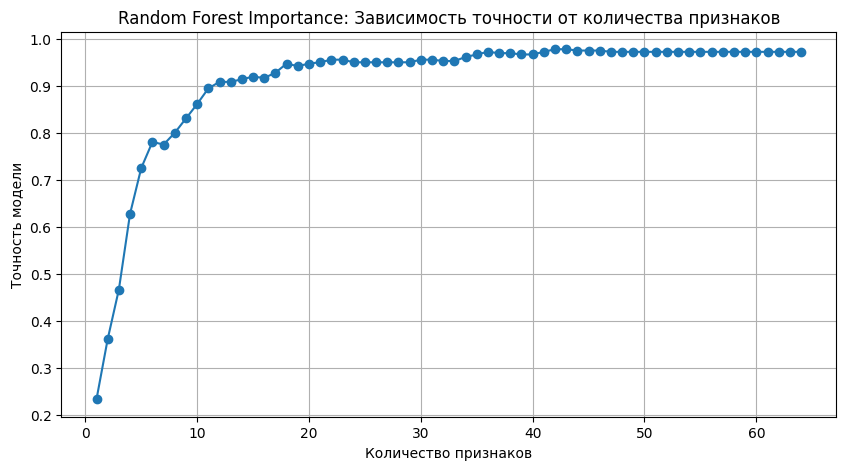

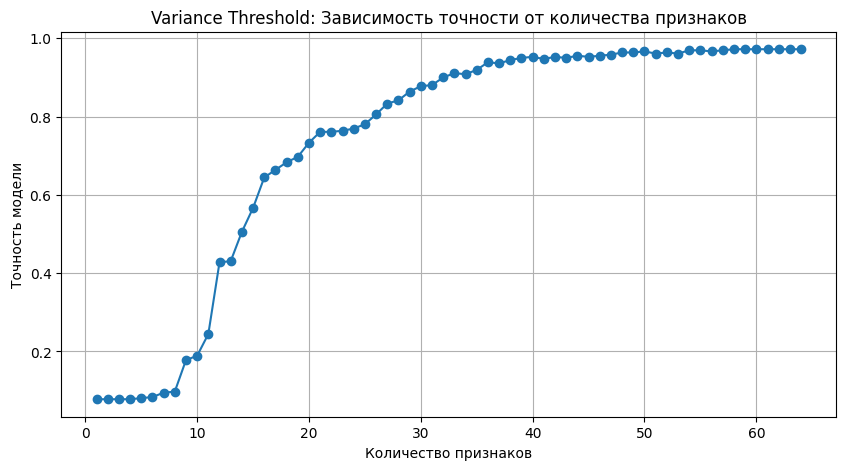

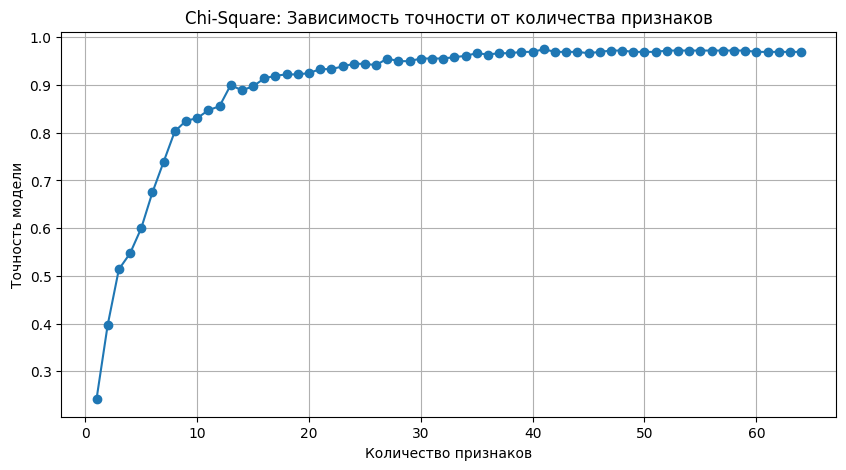

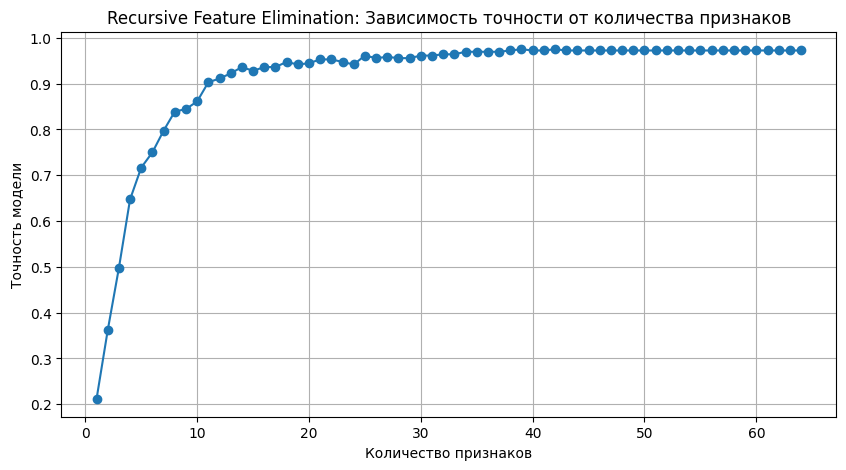

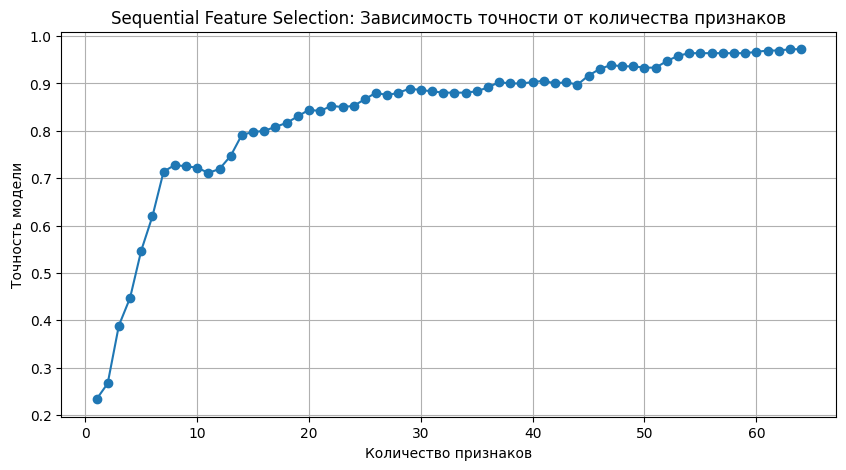

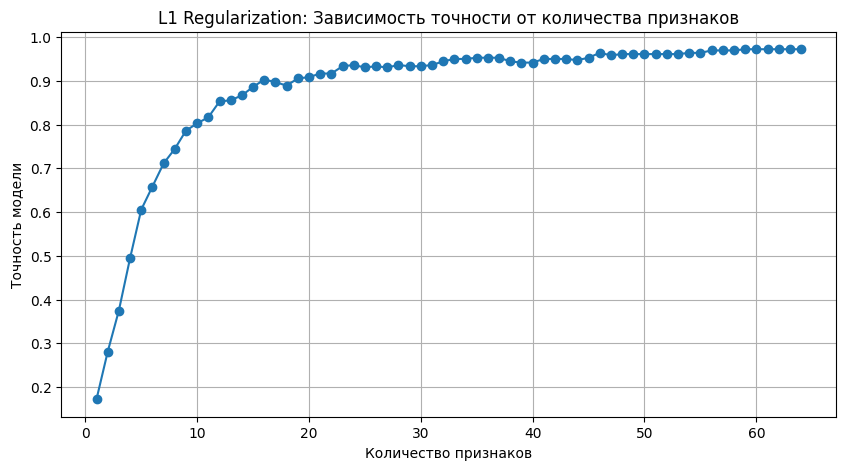

In [242]:
for method_name, selector in methods.items():
    if method_name == "Chi-Square": # для хи-квадрат важно, чтобы все признаки были неотрицательными
        min_val = X_train.min()     # если они есть, они сдвигаются на мин значение, чтобы получить только положительные
        if min_val < 0:
            X_train_proc = X_train - min_val
            X_test_proc = X_test - min_val
        else:
            X_train_proc = X_train
            X_test_proc = X_test
        sorted_indices = selector(X_train_proc, y_train)
    else:
        sorted_indices = selector(X_train, y_train)
        X_train_proc, X_test_proc = X_train, X_test

    num_features_range = range(1, X_train.shape[1] + 1)
    accuracies = []

    for num_features in num_features_range: # перебираем кол-во признаков
        selected_features = sorted_indices[:num_features]
        X_train_selected = X_train_proc[:, selected_features]
        X_test_selected = X_test_proc[:, selected_features]

        model = LogisticRegression(max_iter=1000, random_state=42) # обучение модели и точность
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 5))
    plt.plot(num_features_range, accuracies, marker='o', linestyle='-')
    plt.xlabel("Количество признаков")
    plt.ylabel("Точность модели")
    plt.title(f"{method_name}: Зависимость точности от количества признаков")
    plt.grid()
    plt.show()

Все методы отбора признаков показывают схожую динамику: точность модели быстро растет с увеличением числа признаков до 20-30, после чего прирост замедляется или прекращается. Наилучшие результаты (точность 0.8-0.9) достигаются при использовании 30-40 признаков. Дальнейшее добавление признаков либо незначительно улучшает модель (Chi-Square, L1), либо даже ухудшает (Sequential Feature Selection). Оптимальный баланс между точностью и сложностью модели наблюдается в диапазоне 20-40 признаков.

*3. Изучите возможности библиотеки imbalanced-learn. Примените на данном примере возможности данной библиотеки для оверсемплинга и андерсемплинга выборки.*

Оверсемплинг - увеличение числа объектов миноритарного класса

Андерсемплинг - уменьшение числа объектов мажоритарного класса

In [243]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [244]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train) # сначала изучает распределение
# классов, затем создаёт новую выборку, в которой количество объектов каждого
# класса уравнивается за счёт повторного дублирования объектов миноритарного
# класса.
print("Распределение классов после оверсемплинга:")
print(pd.Series(y_train_ros).value_counts())

Распределение классов после оверсемплинга:
6    154
0    154
3    154
5    154
4    154
1    154
2    154
8    154
9    154
7    154
Name: count, dtype: int64


In [245]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train) # уменьшает
# количество объектов в мажоритарном классе до количества объектов в миноритарном
# (то есть удаляет случайные объекты из мажоритарного класса).
print("\nРаспределение классов после андерсемплинга:")
print(pd.Series(y_train_rus).value_counts())


Распределение классов после андерсемплинга:
0    135
1    135
2    135
3    135
4    135
5    135
6    135
7    135
8    135
9    135
Name: count, dtype: int64


*4. Исследуйте влияние дискретизации целевой переменной на качество модели. Используйте уже продемострированный подход - построение базовой модели (baseline) и сравнение модели после обработки данных с базовой. Проверьте разное количество категорий, а также разные стратегии группировки. Сделайте выводы. Обратите внимание, что после биннинга целевой переменной она стала категориальной. А значит, задача превратилась в задачу классификации.*

**Построение базовой модели**

In [293]:
from sklearn.metrics import mean_squared_error, r2_score

In [294]:
baseline_reg = LinearRegression() # обучение линейной регрессии
baseline_reg.fit(X_train, y_train)

LinearRegression()

In [295]:
y_pred_reg = baseline_reg.predict(X_test) # предсказания и метрики
mse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

In [296]:
print(f"Baseline regression MSE: {mse:.4f}, R²: {r2:.4f}")

Baseline regression MSE: 3.2600, R²: 0.5780


Показатели модели указывают на умеренное качество: объясняется около 57.8% дисперсии данных, но ошибка предсказаний (MSE) относительно высока.

**Дискретизация целевой переменной**

In [297]:
n_bins_list = [3, 5, 10]

for n_bins in n_bins_list:
    y_binned = pd.cut(y, bins=n_bins, labels=False)

    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_binned, test_size=0.3, random_state=42)

    model_clf = LogisticRegression(max_iter=1000)
    model_clf.fit(X_train_clf, y_train_clf)

    accuracy = model_clf.score(X_test_clf, y_test_clf)
    print(f"(bins={n_bins}) - Accuracy: {accuracy:.4f}")

(bins=3) - Accuracy: 0.9352
(bins=5) - Accuracy: 0.9444
(bins=10) - Accuracy: 0.9704


Точность модели растёт с увеличением количества бинов (от 93.5% при 3 бинах до 97% при 10). Это говорит о том, что более детальная разбивка данных улучшает качество классификации. Оптимальный результат достигается при 10 бинах.

**Ручное разбиение**

In [299]:
y_min = y.min()
y_max = y.max()

bins = [y_min - 0.01, 0.5, 1.5, y_max + 0.01]

y_binned = pd.cut(y, bins=bins, labels=False, include_lowest=True)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_binned, test_size=0.3, random_state=42)

model_clf = LogisticRegression(max_iter=1000)
model_clf.fit(X_train_clf, y_train_clf)

accuracy = model_clf.score(X_test_clf, y_test_clf)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9778


Точность модели 97.78% означает, что она почти идеально справляется с задачей классификации.